In [2]:
import json
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import random
import warnings
import datetime as dt
warnings.filterwarnings('ignore')
from dataclasses import asdict

uploaded = pd.read_csv('/kaggle/input/shiftlogs/HomeWork.csv')

uploaded

,Unnamed: 0,status,income,age,date
0,0,Student,4000.0,18.0,2022-01-23
1,1,Pensioner,NaN,91.0,2022-01-19
2,2,Student,4000.0,18.0,2022-01-03
3,3,Student,0.0,NaN,2022-01-13
4,4,Pensioner,5000.0,87.0,2022-01-31
...,...,...,...,...,...
495,495,Pensioner,28000.0,NaN,2022-01-30
496,496,Pensioner,16000.0,64.0,2022-01-20
497,497,Businessman,258000.0,43.0,2022-01-12
498,498,Student,4000.0,17.0,2022-01-19


In [3]:
uploaded['date'] = pd.to_datetime(uploaded['date'], errors='coerce')

<AxesSubplot:xlabel='date'>

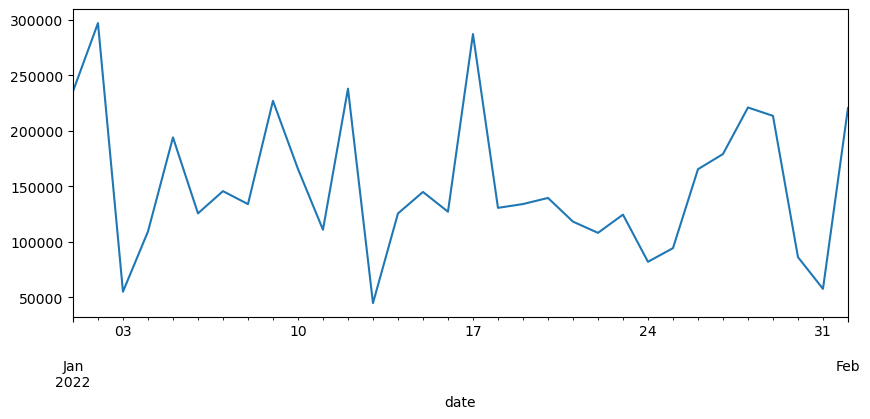

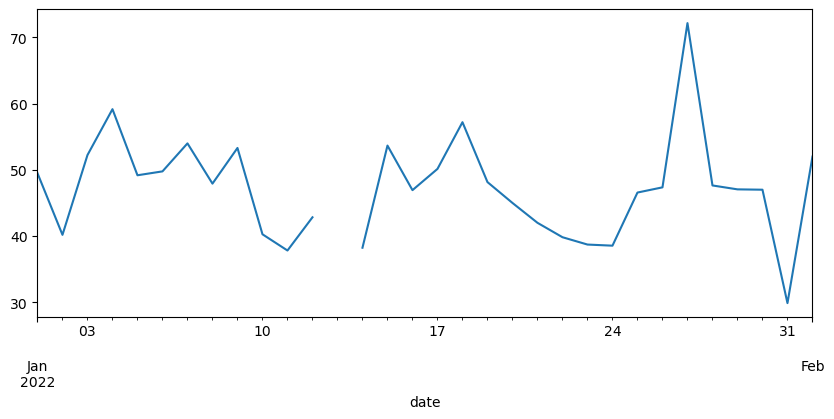

In [4]:

plt.figure(figsize=(10, 4))
uploaded.resample('1d', on='date')['income'].mean().plot()
plt.figure(figsize=(10, 4))
uploaded.resample('1d', on='date')['age'].mean().plot()

In [5]:
# 13 января нет данных о возрасте. Удаляем этот день из датафрейма.

uploaded = uploaded[uploaded['age'].notna()]

Выбросы в доходах оцениваем для каждой группы отдельно

<AxesSubplot:xlabel='income'>

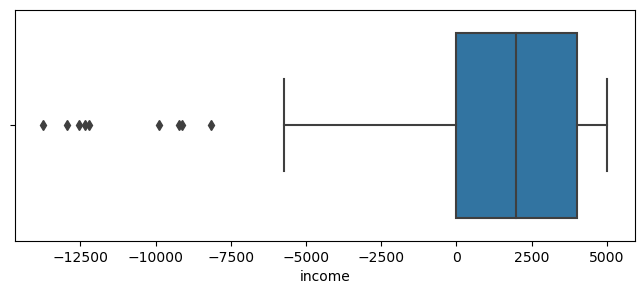

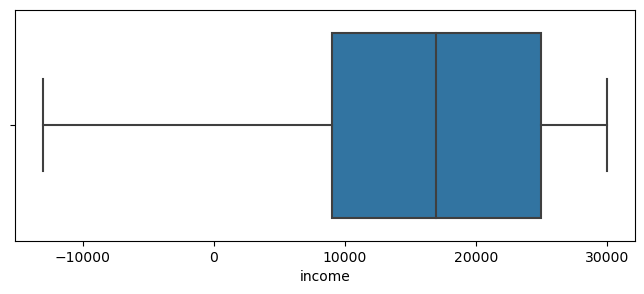

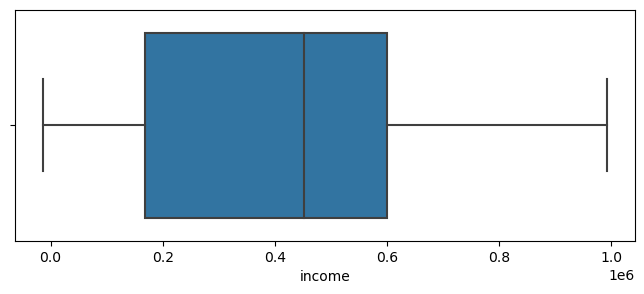

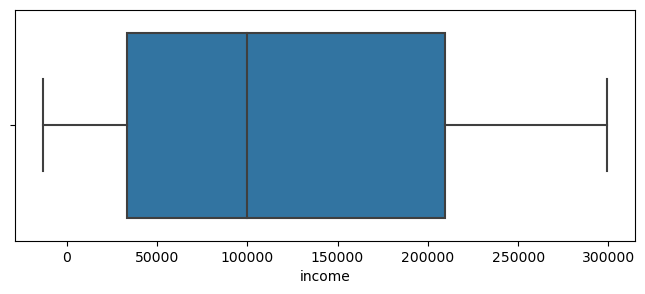

In [6]:
plt.figure(figsize=(8, 3))
sns.boxplot(x=uploaded.loc[uploaded['status'] == 'Student', 'income'])
plt.figure(figsize=(8, 3))
sns.boxplot(x=uploaded.loc[uploaded['status'] == 'Pensioner', 'income'])
plt.figure(figsize=(8, 3))
sns.boxplot(x=uploaded.loc[uploaded['status'] == 'Businessman', 'income'])
plt.figure(figsize=(8, 3))
sns.boxplot(x=uploaded.loc[uploaded['status'] == 'Working', 'income'])

Выбросы есть только в группе Student

In [7]:
def get_outliers_info(df, d = 1.5):
    """
    Статистика по наличию выбросов в признаках.
    df - датасет с признаками 
    d - коэффициент, на который умножается IQR (обычно 1.5, что соотв. усам на boxplot)
    """
    df = df.copy()
    q75 = df.quantile(0.75)
    q25 = df.quantile(0.25)
    iqr = q75 - q25

    feature_list, outlier_list = [], []
    numerical_columns = [c for c in df.columns if df[c].dtype in ['float64', 'int64'] and df[c].nunique()>10]

    for feature in numerical_columns:
        lower_threshold = q25.loc[feature] - d*iqr[feature]
        upper_threshold = q75.loc[feature] + d*iqr[feature]
        
        df['is_outlier'] = np.nan
        df.loc[(df[feature] < lower_threshold) | (df[feature] > upper_threshold), 'is_outlier'] = 1
        df['is_outlier'] = df['is_outlier'].fillna(0)

        feature_list.append(feature)
        outlier_list.append(df['is_outlier'].mean())
        
    outliers_df = pd.DataFrame(index=feature_list, data=outlier_list, columns=['ratio_outliers'])
    outliers_df = outliers_df[outliers_df['ratio_outliers']>0]
    outliers_df = outliers_df.sort_values(by='ratio_outliers', ascending=False)
    
    return outliers_df

In [8]:
outliers_df = get_outliers_info(uploaded)
outliers_df

,ratio_outliers
income,0.086168


Функция и боксплот указывают на то, что выбросы имеются в колонке 'income'. Так как выбросы составляют менее 9% от общего числа, считаю для избежания перекоса работы модели заменить их на ближайший в боксплоте

In [9]:
def iqr_fence(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    Lower_Fence = Q1 - (1.5 * IQR)
    Upper_Fence = Q3 + (1.5 * IQR)
    u = max(x[x<Upper_Fence])
    l = min(x[x>Lower_Fence])
    print(u, l)
    return [u,l]

In [10]:
income_Student = list(iqr_fence(uploaded.loc[uploaded['status'] == 'Student', 'income']))

uploaded.loc[((uploaded['status'] == 'Student') & (uploaded['income'] < income_Student[1])), 'income'] = income_Student[1]

5000.0 -5732.0


<AxesSubplot:xlabel='income'>

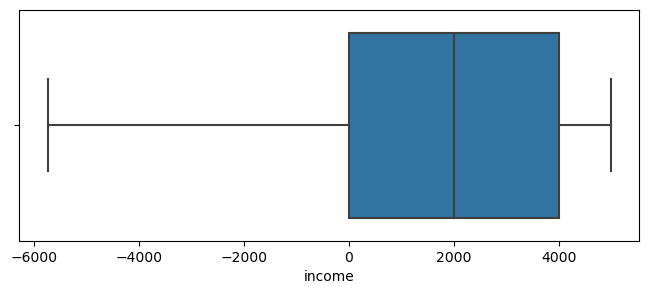

In [11]:
plt.figure(figsize=(8, 3))
sns.boxplot(x=uploaded.loc[uploaded['status'] == 'Student', 'income'])

На боксплоте выбросов больше не наблюдаем

<AxesSubplot:xlabel='age', ylabel='income'>

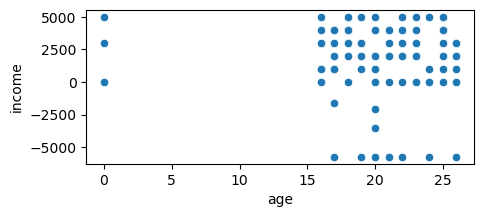

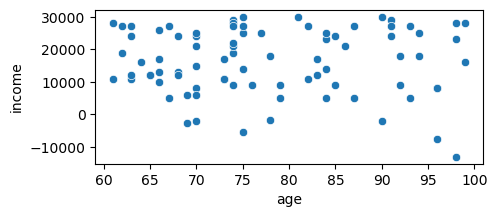

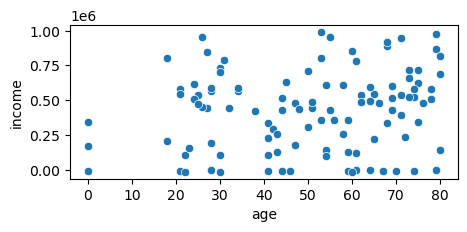

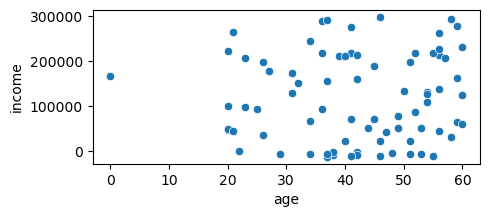

In [12]:
# Продолжим поиск выбросов, построим scatterplot для каждой группы

plt.figure(figsize=(5, 2))
sns.scatterplot(data=uploaded.loc[uploaded['status'] == 'Student'], x="age", y="income")
plt.figure(figsize=(5, 2))
sns.scatterplot(data=uploaded.loc[uploaded['status'] == 'Pensioner'], x="age", y="income")
plt.figure(figsize=(5, 2))
sns.scatterplot(data=uploaded.loc[uploaded['status'] == 'Businessman'], x="age", y="income")
plt.figure(figsize=(5, 2))
sns.scatterplot(data=uploaded.loc[uploaded['status'] == 'Working'], x="age", y="income")

In [20]:
# На scatterplot видим у некоторых людей из групп Student и Pensioner отрицательный доход, а у Businessman и Working нулевой.
# Поскольку на курсе нашей задачей является поиск дефолтных клиентов предлагаю добавить флаг дохода 0 и менее.
# Еще как вариант можно было бы сделать новый статус "Безработный" и добавить туда людей с нулевым доходом из групп
# Businessman и Working. Для групп Student и Pensioner отрицательный и нулевой доход более вероятен и не является выбросом как таковым.


uploaded['флаг дохода 0 и менее'] = np.where(uploaded['income']<=0, 1, 0)
uploaded['флаг дохода 0 и менее'].value_counts()

0    362
1     69
Name: флаг дохода 0 и менее, dtype: int64

Пропуски в столбцах дохода и возраста предлагаю заполнить средним значением для каждой группы.

In [14]:
# заменили 0 в возрасте на Nan
uploaded.loc[(uploaded['age'] == 0), 'age'] = np.nan

# меняем на медиану внутри группы, так как среднее арифметическое может путать модель.
for status in uploaded['status'].unique():
    median = uploaded[uploaded['status'] == status]['age'].median()
    uploaded.loc[(uploaded['status'] == status) & (uploaded['age'].isna()), 'age'] = median
    
for income in uploaded['status'].unique():
    median = uploaded[uploaded['status'] == income]['income'].median()
    uploaded.loc[(uploaded['status'] == income) & (uploaded['income'].isna()), 'income'] = median

In [15]:
# Отсутствующие статусы можно было бы заменить на наиболее часто встерачющиеся, то так как их всего 10, то
# Строки с пустыми статусами удаляем
uploaded = uploaded[uploaded['status'].notna()]

In [16]:
uploaded

,Unnamed: 0,status,income,age,date,флаг дохода 0 и менее
0,0,Student,4000.0,18.0,2022-01-23,0
1,1,Pensioner,17000.0,91.0,2022-01-19,0
2,2,Student,4000.0,18.0,2022-01-03,0
4,4,Pensioner,5000.0,87.0,2022-01-31,0
5,5,Student,1000.0,20.0,2022-01-25,0
...,...,...,...,...,...,...
494,494,Pensioner,9000.0,85.0,2022-01-06,0
496,496,Pensioner,16000.0,64.0,2022-01-20,0
497,497,Businessman,258000.0,43.0,2022-01-12,0
498,498,Student,4000.0,17.0,2022-01-19,0


In [17]:
uploaded.to_csv('hw_32.csv')